In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import csv
import time

import sys
sys.path.insert(0, "../../utils/")
import utils as ut
import fancyplots as fp
from regr_models import neuralNewtorkRegression

import numpy as np
import matplotlib.pyplot as plt

## Input options

In [3]:
data2use     = 'GSTLAL_m1m2Mc' # 'NewRealistic', 'GSTLAL_2m' or 'GSTLAL_m1m2Mc'
                               # in the latter case, the regression is done only on m1,m2, Mc is not considered
                               # even if it is in the dataset

# training options
write_output     = True
remove_some_mass = False
epochs           = 50
validation_split = 0.2
batch_size       = 128
verbose_training = False
hlayers_sizes    = (100,);
learning_rate    = 0.001
scaler_type      = 'minmax'  # standard, minmax, mixed
hidden_activation= 'relu'
out_activation   = 'linear' # sigmoid, linear, linear_cut, linear_cut_T3, linear_cut_lb, linear_cut_mod

## Load data

In [4]:
if data2use=='NewRealistic':
    features_names   = ['m1', 'm2', 's1x', 's1y', 's1z', 's2x', 's2y', 's2z',\
                        'theta', 'q', 'Mc'];
    regr_data_dir    = '../../datasets/NewRealistic/'
    out_data_dir     = '../../datasets/NN_tf_results/'
    versions         = ['0'] # can be a subset of ['0', '1', '2']
    clabels          = ['0'] # can be a subset of ['0', '1'] 

    # define dictionary for each version considered
    Nv       = len(versions)
    Nc       = len(clabels)
    Nsets    = Nv*Nc

    if Nv*Nc!=Nsets:
        print('+++ Wrong input! +++')

    datasets = {}
    keys     = []
    for i in range(0,Nv):
        version = versions[i]
        for j in range(0,Nc):
            clabel = clabels[j]
            key = 'v'+version+'c'+clabel
            keys.append(key)
            datasets[key]         = lambda:0
            datasets[key].clabel  = clabel
            datasets[key].version = version
            data_paths           = {}
            data_paths['xtrain'] = regr_data_dir+key+'train_x.csv'
            data_paths['ytrain'] = regr_data_dir+key+'train_y.csv'
            data_paths['xtest']  = regr_data_dir+key+'test_x.csv'
            data_paths['ytest']  = regr_data_dir+key+'test_y.csv'
            datasets[key].data_paths = data_paths
    idx_Mc = 10
    
elif data2use=='GSTLAL_2m':
    features_names    = ['m1', 'm2']
    regr_data_dir     = '../../datasets/GSTLAL_EarlyWarning_Dataset/Dataset/'
    out_data_dir      = '../../datasets/GSTLAL_EarlyWarning_Dataset/Regression_Result/NN_tf/'
    datasets          = {}
    keys              = ['GSTLAL_2m']
    key               = keys[0]
    datasets[key]     = lambda:0
    data_paths           = {}
    data_paths['xtrain'] = regr_data_dir+'train_recover.csv'
    data_paths['ytrain'] = regr_data_dir+'train_inject.csv'
    data_paths['xtest']  = regr_data_dir+'test_recover.csv'
    data_paths['ytest']  = regr_data_dir+'test_inject.csv'
    
    datasets[key].data_paths = data_paths
    idx_Mc = None

elif data2use=='GSTLAL_m1m2Mc':
    features_names    = ['m1', 'm2']
    regr_data_dir     = '../../datasets/GSTLAL_EarlyWarning_Dataset/Dataset/m1m2Mc/'
    out_data_dir      = '../../datasets/GSTLAL_EarlyWarning_Dataset/Dataset/m1m2Mc/Regression_results/'
    datasets          = {}
    keys              = ['GSTLAL_m1m2Mc']
    key               = keys[0]
    datasets[key]     = lambda:0
    data_paths           = {}
    data_paths['xtrain'] = regr_data_dir+'xtrain.csv'
    data_paths['ytrain'] = regr_data_dir+'ytrain.csv'
    data_paths['xtest']  = regr_data_dir+'xtest.csv'
    data_paths['ytest']  = regr_data_dir+'ytest.csv'
    
    datasets[key].data_paths = data_paths
    idx_Mc = None
    
else:
    print("'data2use' can be 'NewRealistic', 'GSTLAL_2m' or 'GSTLAL_m1m2Mc'")
    sys.exit()

## Train and test the model on the dataset(s)

********************************************************************************
Key: GSTLAL_m1m2Mc
********************************************************************************
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 100)               300       
                                                                 
 dense_1 (Dense)             (None, 2)                 202       
                                                                 
Total params: 502
Trainable params: 502
Non-trainable params: 0
_________________________________________________________________

Final loss     : 0.02767
Final R2 mean  : 0.75478
R2[ 0]         : 0.72998
R2[ 1]         : 0.77957


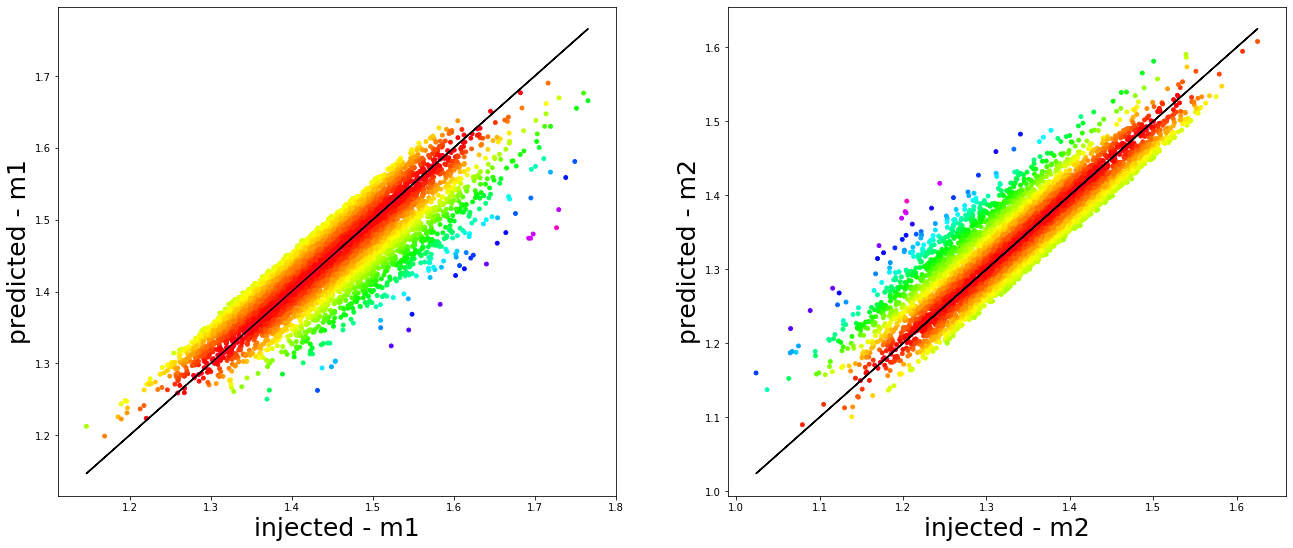

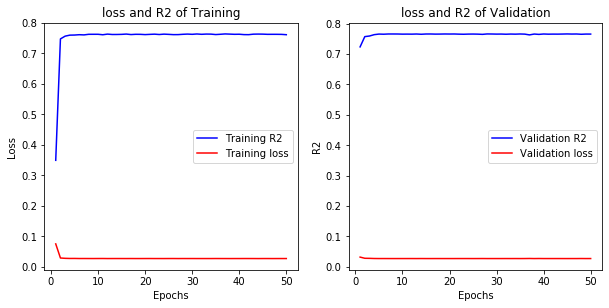

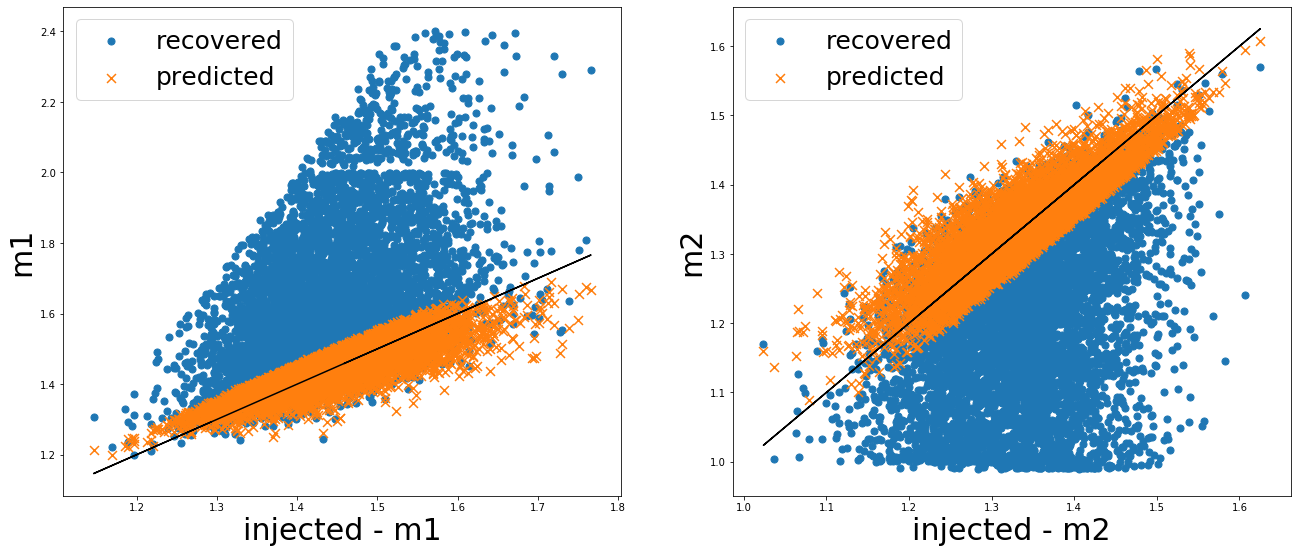

********************************************************************************
m1 vs m2: injected, recovered, predicted
********************************************************************************


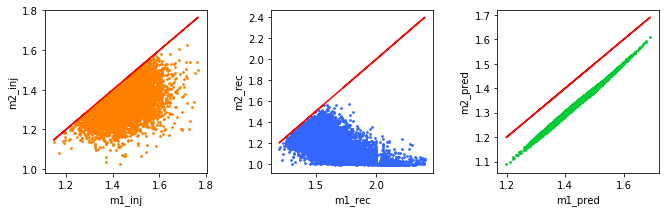

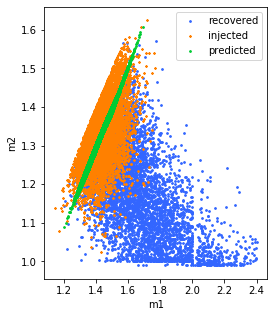

********************************************************************************
m1 vs q: injected, recovered, predicted (indirectly)
********************************************************************************


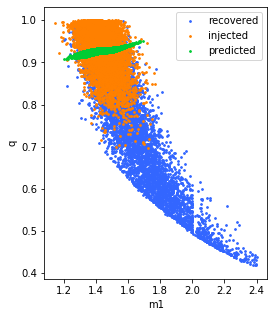

In [5]:
asterisks = '*'*80

for key in keys:
    print(asterisks, '\nKey: ', key, '\n', asterisks, sep='')
    
    rdl_out = ut.regressionDatasetLoader(data_paths, features_names,
                           remove_some_mass=remove_some_mass,
                           scaler_type=None)
    xtrain_notnormalized = rdl_out['xtrain']
    ytrain_notnormalized = rdl_out['ytrain']
    xtest_notnormalized  = rdl_out['xtest']
    ytest_notnormalized  = rdl_out['ytest']
    labels               = rdl_out['labels']
    
    # to use if m1m2Mc is loaded 
    if data2use=='GSTLAL_m1m2Mc':
        # remove Mc
        xtrain_notnormalized = xtrain_notnormalized[:,0:2]
        ytrain_notnormalized = ytrain_notnormalized[:,0:2]
        xtest_notnormalized  = xtest_notnormalized[:,0:2]
        ytest_notnormalized  = ytest_notnormalized[:,0:2]
        labels               = labels[0:2]
        
    t0 = time.perf_counter()
    outNN = neuralNewtorkRegression(xtrain_notnormalized, ytrain_notnormalized,
                scaler_type       = scaler_type,                   
                epochs            = epochs, 
                batch_size        = batch_size, 
                learning_rate     = learning_rate,          
                validation_split  = validation_split,   
                verbose           = verbose_training,             
                hlayers_sizes     = hlayers_sizes,          
                out_activation    = out_activation,        
                hidden_activation = hidden_activation,
                loss_function     = 'mse'
            )
    train_time = time.perf_counter()-t0
    
    model    = outNN["model"]
    history  = outNN["history"]
    scaler_x = outNN["scaler_x"]
    scaler_y = outNN["scaler_y"]

    if not verbose_training:
        model.summary()
        
    xtest = scaler_x.transform(xtest_notnormalized)
    ytest = scaler_y.transform(ytest_notnormalized)
    
    # predict
    ypredicted = model.predict(xtest)
    
    # print some information
    metrics_dict = ut.evalutationMetricsDict(xtest,ytest,model)
    ut.printMetrics(metrics_dict)

    # update dictionary adding data (both normalized and not), model and score
    datasets[key].train_time = train_time
    datasets[key].model      = model
    datasets[key].history    = history
    datasets[key].predicted  = scaler_y.inverse_transform(ypredicted)
    datasets[key].metrics    = metrics_dict
    datasets[key].Ntrain     = len(xtrain_notnormalized[:,0])
    
    # plots
    fp.regrPredictionPlots(ytest, ypredicted, labels, scaler=scaler_y)
    fp.plotHistory(history)
    fp.checkRegressionPlot(xtest, ytest, ypredicted, labels, \
                       scaler_y=scaler_y, scaler_x=scaler_x)
    fp.plotInjRecPred(ytest_notnormalized, xtest_notnormalized, \
                      datasets[key].predicted, idx_Mc=idx_Mc, hide_recovered=False)
    del model

## Produce CSV files

In [6]:
if write_output:
    for key in keys:
        # save csv
        filename = out_data_dir+'NN_tf_'+key+'.csv'
        ut.writeResult(filename, datasets[key].predicted, verbose=True)
        
        # save model
        #dict_name = out_data_dir+'NN_tf_'+key+'.dict'
        #pickle.dump(datasets[key].model, open(dict_name, 'wb'))
        #print(dict_name, 'saved') 
        
        # example for loading models
        #dict_name    = out_data_dir+'NN_tf_'+key+'.dict'
        #print('Loading', dict_name, '...')
        #loaded_model = pickle.load(open(dict_name, 'rb'))

../../datasets/GSTLAL_EarlyWarning_Dataset/Dataset/m1m2Mc/Regression_results/NN_tf_GSTLAL_m1m2Mc.csv saved
